In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


RendererRegistry.enable('notebook')

In [2]:
results = pd.read_csv("../src/output/aura_output_1.csv", delimiter=";", index_col=["Dataset", "Classifier"])

In [3]:
results

Fit time  \
Dataset         Classifier                                                     
adult           Nearest Neighbors                                     0.3414   
                Linear SVM                                          600.0000   
                RBF SVM                                             600.0000   
                Gaussian Process                                    600.0000   
                Decision Tree                                         0.3127   
                Random Forest                                        16.6492   
                Neural Net                                           25.7229   
                AdaBoost                                              7.1172   
                Naive Bayes                                           0.1871   
                QDA                                                   0.2743   
                NN-(300, 100)-relu-sigmoid-mean_squared_error        43.9048   
                NN-(300, 100)-relu-softmax-crossentropy              36.6117   
                NN-(500, 300)-relu-sigmoid-mean_squared_error        83.1769   
                NN-(500, 300)-relu-softmax-crossentropy              68.2340   
                NN-(500, 500, 2000)-relu-sigmoid-mean_squared_e...  600.0000   
                NN-(500, 500, 2000)-relu-softmax-crossentropy       600.0000   
allbp           Nearest Neighbors                                     0.0135   
                Linear SVM                                            0.7039   
                RBF SVM                                               0.3765   
                Gaussian Process                                    600.0000   
                Decision Tree                                         0.0141   
                Random Forest                                         1.5388   
                Neural Net                                           20.6178   
                AdaBoost                                              1.4154   
                Naive Bayes                                           0.0110   
                QDA                                                   0.0675   
                NN-(300, 100)-relu-sigmoid-mean_squared_error        11.6101   
                NN-(300, 100)-relu-softmax-crossentropy              15.9707   
                NN-(500, 300)-relu-sigmoid-mean_squared_error        22.9780   
                NN-(500, 300)-relu-softmax-crossentropy              20.6975   
...                                                                      ...   
sphere_3classes RBF SVM                                               1.1096   
                Gaussian Process                                    600.0000   
                Decision Tree                                         0.0573   
                Random Forest                                         1.4354   
                Neural Net                                           14.6952   
                AdaBoost                                              0.3715   
                Naive Bayes                                           0.0024   
                QDA                                                   0.0126   
                NN-(300, 100)-relu-sigmoid-mean_squared_error         5.5080   
                NN-(300, 100)-relu-softmax-crossentropy               5.3954   
                NN-(500, 300)-relu-sigmoid-mean_squared_error         8.1824   
                NN-(500, 300)-relu-softmax-crossentropy               9.3567   
                NN-(500, 500, 2000)-relu-sigmoid-mean_squared_e...   33.3928   
                NN-(500, 500, 2000)-relu-softmax-crossentropy        26.4749   
weapon          Nearest Neighbors                                     0.0687   
                Linear SVM                                            1.0408   
                RBF SVM                                               0.8592   
                Gaussian Process                                    

In [4]:
mir_r  =  pd.read_csv("../src/output/output_2.csv", delimiter=";",  index_col=["Dataset", "Classifier"])

In [5]:
for index, row in mir_r.iterrows():
    results.loc[index, row.index] = row.values

In [6]:
# results = concat.loc[~(concat["Fit time"] == 600)]
results = results.reset_index()

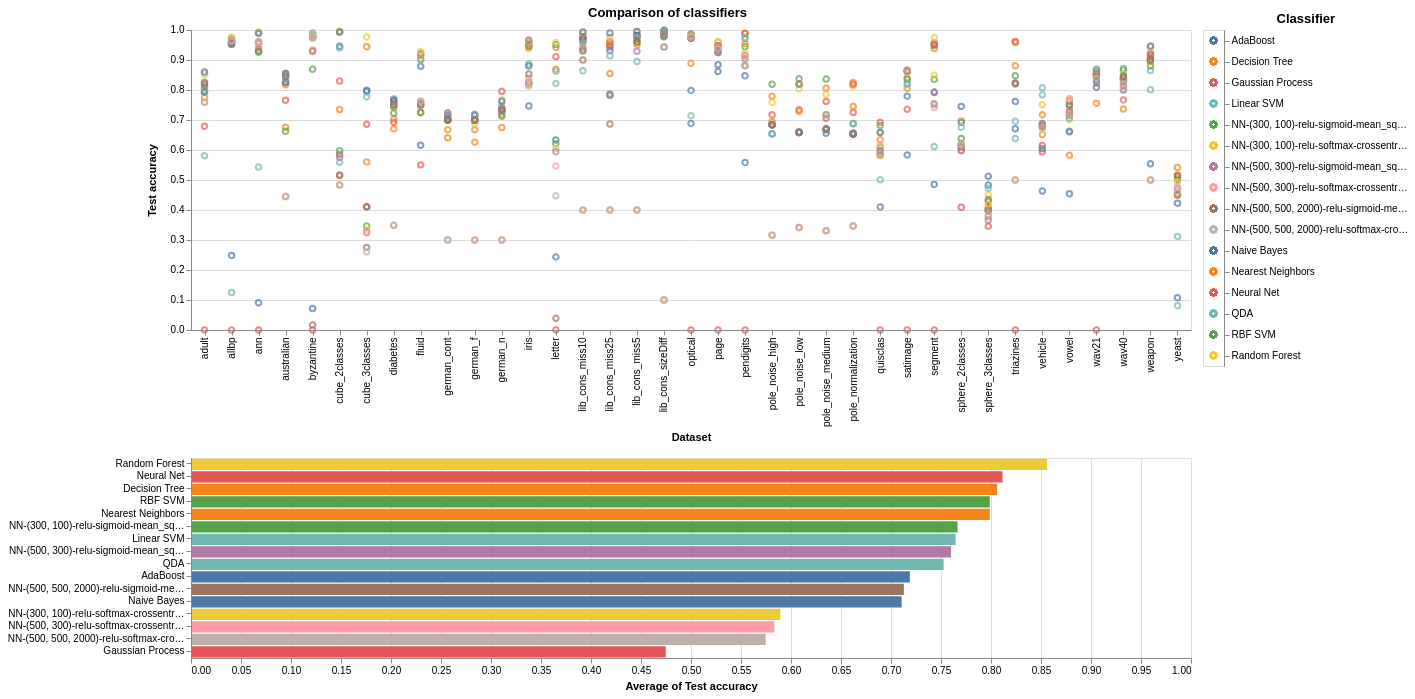

In [7]:
selection = alt.selection_multi(fields=["Classifier"])
brush = alt.selection(type="interval")

predicate = selection | brush

color = alt.condition(
    predicate, alt.Color("Classifier:N", legend=None), alt.value("lightgray")
)


points = (
    alt.Chart()
    .mark_point()
    .encode(
        x=alt.X("Dataset"),
        y=alt.Y("Test accuracy:Q", scale=alt.Scale(domain=(0, 1))),
        color=alt.condition(
            predicate, alt.Color("Classifier:N", legend=None), alt.value("lightgray")
        ),
        tooltip=[
            "Classifier:N",
            alt.Text("Test accuracy:Q", title="Accuracy", format=".3f"),
            "Dataset:N",
        ],
    )
    .add_selection(brush, selection)
    .properties(width=1000, height=300, title="Comparison of classifiers")
)

legend = (
    alt.Chart()
    .mark_point()
    .encode(
        y=alt.Y("Classifier:N", axis=alt.Axis(orient="right"), title=""),
        color=alt.condition(
            selection, alt.Color("Classifier:N", legend=None), alt.value("lightgray")
        ),
    )
    .add_selection(selection)
    .properties(title="Classifier")
)

bars = (
    alt.Chart()
    .mark_bar()
    .encode(
        y=alt.Y(
            "Classifier:N",
            sort=alt.EncodingSortField(
                field="Test accuracy", op="mean", order="descending"
            ),
            title="",
        ),
        color=alt.Color("Classifier:N", legend=None),
        tooltip=[
            "Classifier:N",
            alt.Text("average(Test accuracy):Q", title="Average accuracy", format=".3f"),
        ],
        x=alt.X("average(Test accuracy):Q", scale=alt.Scale(domain=(0, 1))),
    )
    .transform_filter(predicate)
    .properties(width=1000, height=200)
)

chart = alt.vconcat(alt.hconcat(points, legend, data=results), bars, data=results)

chart

In [8]:
chart.save("results.html")

# Wilcoxon

In [9]:
from scipy.stats import wilcoxon
from itertools import product

In [10]:
classifiers = results['Classifier'].unique()
datasets = results['Dataset'].unique()

reshaped = results.pivot(index='Classifier',
                         columns='Dataset',
                         values='Test accuracy')
wilcoxon_res = pd.DataFrame(columns=classifiers, index=classifiers)

for clf_a, clf_b in product(classifiers, repeat=2):
    if clf_a == clf_b:
        continue
        
    a = reshaped.loc[clf_a].values
    b = reshaped.loc[clf_b].values
    
    z_stat, p_val = wilcoxon(a,b)
    wilcoxon_res.at[clf_a, clf_b] = p_val
    
wilcoxon_res.fillna(0, inplace=True)
wilcoxon_res.to_csv('wilcoxon.csv')     
wilcoxon_res

,Nearest Neighbors,Linear SVM,RBF SVM,Gaussian Process,Decision Tree,Random Forest,Neural Net,AdaBoost,Naive Bayes,QDA,"NN-(300, 100)-relu-sigmoid-mean_squared_error","NN-(300, 100)-relu-softmax-crossentropy","NN-(500, 300)-relu-sigmoid-mean_squared_error","NN-(500, 300)-relu-softmax-crossentropy","NN-(500, 500, 2000)-relu-sigmoid-mean_squared_error","NN-(500, 500, 2000)-relu-softmax-crossentropy"
Nearest Neighbors,0.000000,0.066801,0.086804,0.000928,4.924445e-01,5.028350e-06,0.058307,0.176938,0.050736,0.728595,0.242322,2.391918e-04,0.073288,1.310472e-04,2.606599e-02,5.806185e-05
Linear SVM,0.066801,0.000000,0.049547,0.005770,3.613897e-01,1.056580e-05,0.004899,0.623914,0.190905,0.419593,0.850592,1.346860e-04,0.626081,8.576055e-05,2.701465e-01,3.851131e-05
RBF SVM,0.086804,0.049547,0.000000,0.001419,4.283432e-01,1.574571e-03,0.768618,0.073816,0.013343,0.226360,0.073292,1.449325e-05,0.008857,8.124671e-06,3.682501e-03,2.953314e-06
Gaussian Process,0.000928,0.005770,0.001419,0.000000,3.509352e-03,1.233116e-06,0.000039,0.001346,0.006548,0.000535,0.009108,3.014049e-01,0.014252,3.457288e-01,3.903934e-02,3.774739e-01
Decision Tree,0.492445,0.361390,0.428343,0.003509,0.000000e+00,1.140214e-07,0.125700,0.066042,0.016117,0.604145,0.287518,1.311051e-04,0.167465,1.089996e-04,6.034799e-02,5.807595e-05
Random Forest,0.000005,0.000011,0.001575,0.000001,1.140214e-07,0.000000e+00,0.001090,0.000175,0.000001,0.000054,0.000002,4.503005e-07,0.000002,3.842337e-07,9.077227e-07,2.193555e-07
Neural Net,0.058307,0.004899,0.768618,0.000039,1.257003e-01,1.089907e-03,0.000000,0.056338,0.009257,0.165150,0.016117,5.446724e-05,0.004674,4.787742e-05,1.211943e-03,1.544664e-05
AdaBoost,0.176938,0.623914,0.073816,0.001346,6.604218e-02,1.749506e-04,0.056338,0.000000,0.561355,0.602721,0.369381,2.606387e-02,0.406676,1.611517e-02,8.622606e-01,1.307466e-02
Naive Bayes,0.050736,0.190905,0.013343,0.006548,1.611668e-02,1.058637e-06,0.009257,0.561355,0.000000,0.037505,0.221556,3.278227e-02,0.366884,1.897861e-02,8.042122e-01,1.150452e-02
QDA,0.728595,0.419593,0.226360,0.000535,6.041451e-01,5.398241e-05,0.165150,0.602721,0.037505,0.000000,0.561355,2.614569e-03,0.499317,1.837191e-03,2.610435e-01,1.033247e-03


In [11]:
classifiers = set(results["Classifier"])

In [12]:
comparison = pd.DataFrame(columns=["Classifier 1", "Classifier 2", "p-value"])
for cl1, cl2 in product(classifiers, classifiers):
    acc_cl1 = results[results["Classifier"] == cl1]["Test accuracy"]
    acc_cl2 = results[results["Classifier"] == cl2]["Test accuracy"]
    #print(len(acc_cl1), len(acc_cl2))
    comparison = comparison.append(
        {
            "Classifier 1": cl1, 
            "Classifier 2": cl2, 
            "p-value": wilcoxon(acc_cl1, acc_cl2).pvalue
        }, 
        ignore_index=True
    )

/home/ondrej/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/ondrej/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2413: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


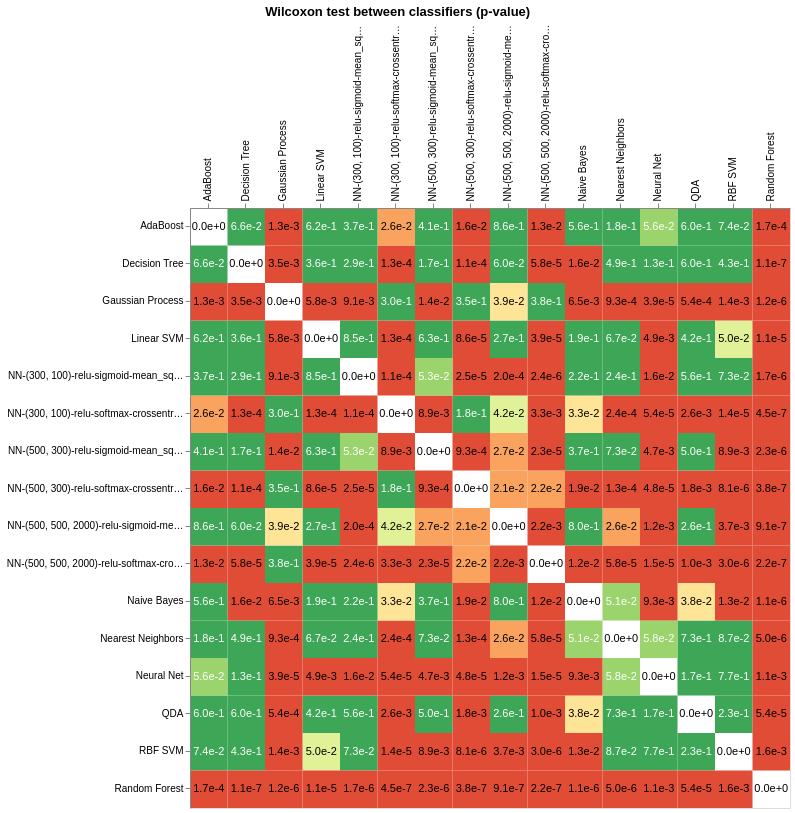

In [13]:
base = alt.Chart(comparison)
scale = alt.Scale(paddingInner=0)

# Configure heatmap
heatmap = base.mark_rect().encode(
    alt.X('Classifier 1:O', scale=scale, axis=alt.Axis(title="", orient="top", labelAngle=-90)),
    alt.Y('Classifier 2:O', scale=scale, axis=alt.Axis(title="")),
    color=alt.Color('p-value:Q', condition=[
        alt.ConditionalPredicateValueDef(alt.FieldLTPredicate("p-value", 0.02), "#e04c36"),
        alt.ConditionalPredicateValueDef(alt.FieldRangePredicate("p-value", [0.02, 0.03]), "#faa35e"),
        alt.ConditionalPredicateValueDef(alt.FieldRangePredicate("p-value", [0.03, 0.04]), "#fde496"),
        alt.ConditionalPredicateValueDef(alt.FieldRangePredicate("p-value", [0.04, 0.05]), "#e1f197"),
        alt.ConditionalPredicateValueDef(alt.FieldRangePredicate("p-value", [0.05, 0.06]), "#9bd46c"),
        alt.ConditionalPredicateValueDef(alt.FieldGTPredicate("p-value", 0.06), "#3ea657"),
        ],
        legend=None
    ),
).properties(width=600, height=600, title="Wilcoxon test between classifiers (p-value)")

# Configure text
text = base.mark_text(baseline='middle').encode(
    x='Classifier 1:O',
    y='Classifier 2:O',
    text=alt.Text('p-value', format=".1e"),
    color=alt.condition(
        alt.FieldRangePredicate("p-value", [0, 0.05]),
        alt.value('black'),
        alt.value('white'),
    )
).properties(width=600, height=600)

# Draw the chart
heatmap = heatmap + text
heatmap

In [14]:
heatmap.save("heatmap.html")